In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time

In [2]:
from dataset import plot_features
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
def Z_norm(X):
    X_mean=X.mean(dtype=np.float32)
    X_std=X.std(dtype=np.float32)
    return (X-X_mean)/X_std, X_mean, X_std

def Z_norm_reverse(X,Xscaler,units_convert=1.0):
    return (X*Xscaler[1]+Xscaler[0])*units_convert

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
# data_path = root_dir +  'processed_data/N2O_data/'
output_path = root_dir + 'test_results/'
input_data = 'input16_output5_finetune_augmented.sav' 
y_augment_mask = 'input16_output5_finetune_augmentation_Ymask.sav' # Augment data mask

# input_data = 'input16_output5_finetune.sav'

data_path = root_dir +  'processed_data/N2O_data/'
output_path = root_dir + 'test_results/'

data0=torch.load(data_path + input_data, weights_only=False)
scaler_data = torch.load(data_path + 'input16_output5_scalers.sav', weights_only=False)
y_argu_mask = torch.load(data_path + y_augment_mask, weights_only=False)

In [7]:
data0.shape, scaler_data.shape, y_argu_mask.shape

((6, 366000, 21), (21, 2), (6, 366000, 5))

In [8]:
# Get output features' scaler values: [Mean, Std]
y_data = data0[...,16:]
y_scaler = []
for i in range(5):
    _data = y_data[...,i].reshape(-1)
    _mean = _data.mean()
    _std  = _data.std()
    y_scaler.append([_mean, _std])
y_scaler = np.array(y_scaler)

In [9]:
y_scaler.shape

(5, 2)

In [10]:
# Z_norm for 5 output features

# 1) Extract means and stds as 1D arrays of length 5:
means = y_scaler[:, 0]  # shape (5,)
stds  = y_scaler[:, 1]  # shape (5,)

# 2) Pull out shape info
n_runs, n_samples, n_feats = data0.shape  # -> 6, 366000, 21

# 3) Flatten the first two dims so we have a 2D array: (6*1000, 21)
flat = data0.reshape(-1, n_feats)         # shape = (6000, 21)

# 4) Z-normalize each column (5 features) in one vectorized step:
flat[:, -5:] = (flat[:, -5:] - means) / stds

# 5) Un-flatten back to (6, 1000, 21)
data_scaled = flat.reshape(n_runs, n_samples, n_feats)

In [11]:
input_features = ['FERTZR_N', 'RADN', 'TMAX_AIR', 'TMIN_AIR', 'HMAX_AIR', 'HMIN_AIR', 'WIND', 'PRECN', 'PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
output_features = ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']
features = input_features + output_features

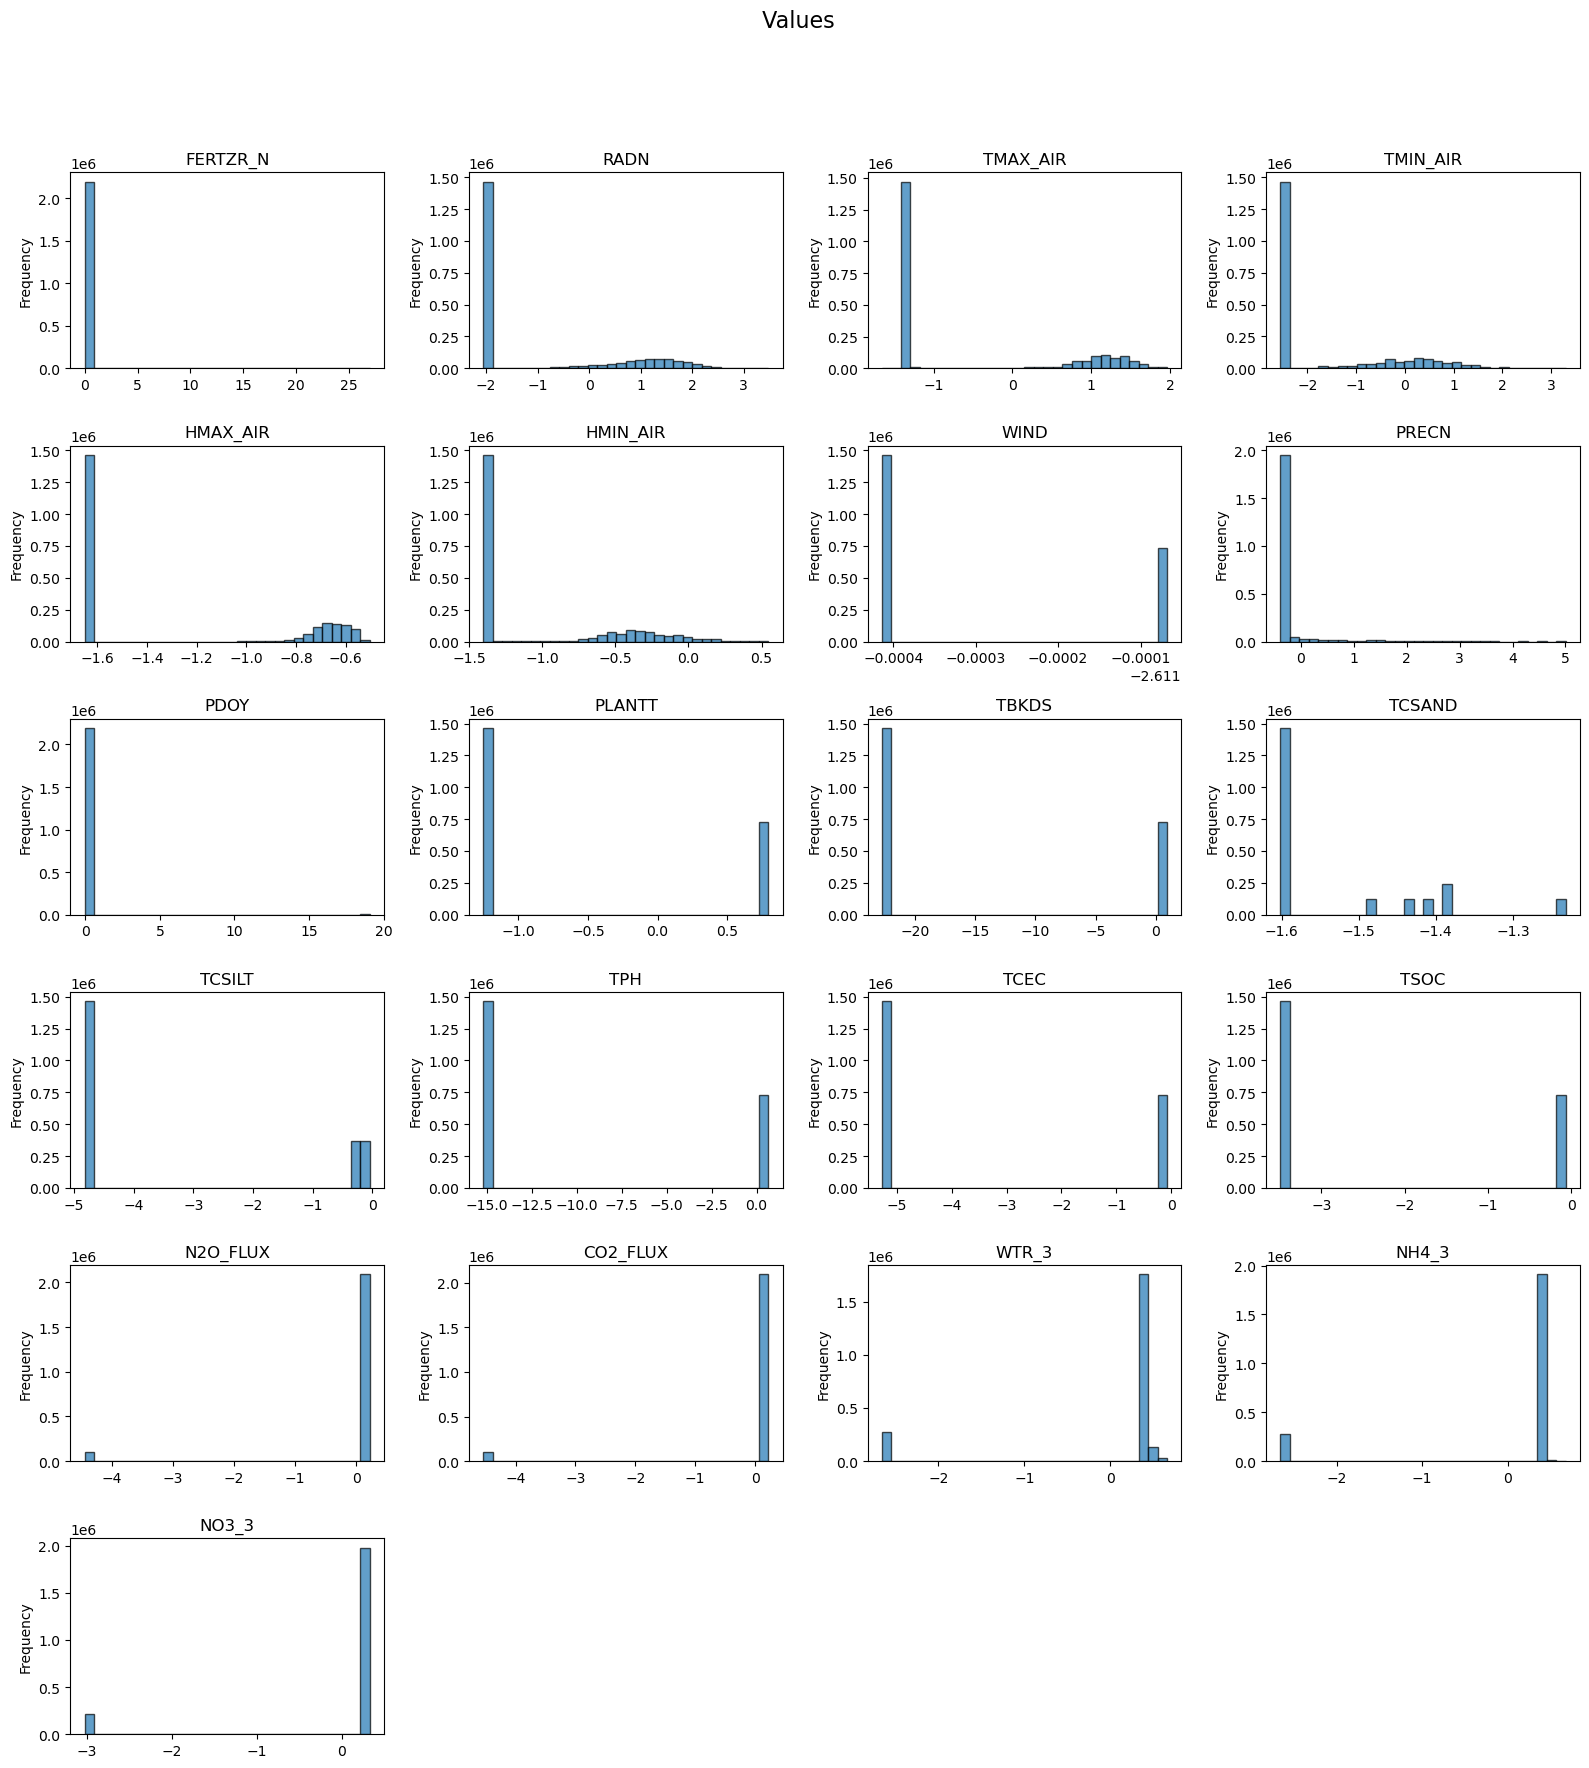

In [12]:
values = data_scaled.reshape(-1, 21)
sub_title = " Values"
plot_features(values, 21, features, sub_title)

In [13]:
# Add Mask to whole dataset
data_with_mask = np.concatenate((data_scaled, y_argu_mask), axis=2)
data_with_mask.shape

(6, 366000, 26)

In [14]:
# Shuffle the site order
site_num = data_with_mask.shape[0]
site_random_list = np.random.choice(site_num, size=site_num, replace=False) # without replacement
site_random_list

array([5, 2, 1, 3, 4, 0], dtype=int32)

In [15]:
# pickup last two sites as test
train_site = site_random_list[:4]
test_site = site_random_list[4:]

In [16]:
# Split input features and output features and masks
X_train = data_with_mask[train_site,:, :16]
Y_train = data_with_mask[train_site,:, 16:]

X_test = data_with_mask[test_site,:, :16]
Y_test = data_with_mask[test_site,:, 16:]

In [17]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4, 366000, 16), (2, 366000, 16), (4, 366000, 10), (2, 366000, 10))

In [18]:
def reshape_aug_data(input_data, unit=1000):
    site, days, features = input_data.shape
    return input_data.reshape(int(site*unit), int(days/unit), features)

In [19]:
X_train = reshape_aug_data(X_train)
X_test  = reshape_aug_data(X_test)

Y_train = reshape_aug_data(Y_train)
Y_test  = reshape_aug_data(Y_test)

In [20]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4000, 366, 16), (2000, 366, 16), (4000, 366, 10), (2000, 366, 10))

In [21]:
n2o_finetune_file = data_path + 'n2o_finetune_augment_data.sav'
torch.save({'X_train': X_train,
            'X_test': X_test,
            'Y_train': Y_train,
            'Y_test': Y_test,
            'y_scaler': y_scaler,
            'input_features':input_features,
            'output_features': output_features}, n2o_finetune_file)

In [22]:
# Set parameters for create a Module
num_input_features = 16
num_output_features = 5

input_dim = num_input_features
hidden_dim = 128
num_layers = 5
output_dim = num_output_features
dropout=0.2

In [23]:
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [24]:
# Create Pytorch dataloader
sequence_length = 122  # Use one year's consecutive days records as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [25]:
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
loss_function = nn.L1Loss() #nn.MSELoss()

# Need use the masks when calculate loss
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch, use_y_mask =True)

Epoch 1/200 | LR: 0.001000, Train Loss: 0.0058, Test Loss: 0.0027
Epoch 2/200 | LR: 0.001000, Train Loss: 0.0034, Test Loss: 0.0029
Epoch 3/200 | LR: 0.001000, Train Loss: 0.0032, Test Loss: 0.0026
Epoch 4/200 | LR: 0.001000, Train Loss: 0.0031, Test Loss: 0.0030
Epoch 5/200 | LR: 0.001000, Train Loss: 0.0029, Test Loss: 0.0039
Epoch 6/200 | LR: 0.001000, Train Loss: 0.0028, Test Loss: 0.0037
Epoch 7/200 | LR: 0.001000, Train Loss: 0.0027, Test Loss: 0.0034
Epoch 8/200 | LR: 0.001000, Train Loss: 0.0027, Test Loss: 0.0037
Epoch 9/200 | LR: 0.001000, Train Loss: 0.0026, Test Loss: 0.0025
Epoch 10/200 | LR: 0.001000, Train Loss: 0.0024, Test Loss: 0.0025
Epoch 11/200 | LR: 0.001000, Train Loss: 0.0023, Test Loss: 0.0025
Epoch 12/200 | LR: 0.001000, Train Loss: 0.0023, Test Loss: 0.0026
Epoch 13/200 | LR: 0.001000, Train Loss: 0.0025, Test Loss: 0.0024
Epoch 14/200 | LR: 0.001000, Train Loss: 0.0022, Test Loss: 0.0023
Epoch 15/200 | LR: 0.001000, Train Loss: 0.0022, Test Loss: 0.0022
Epoc

In [26]:
model.test(use_y_mask=True)

Test Loss: 0.0016


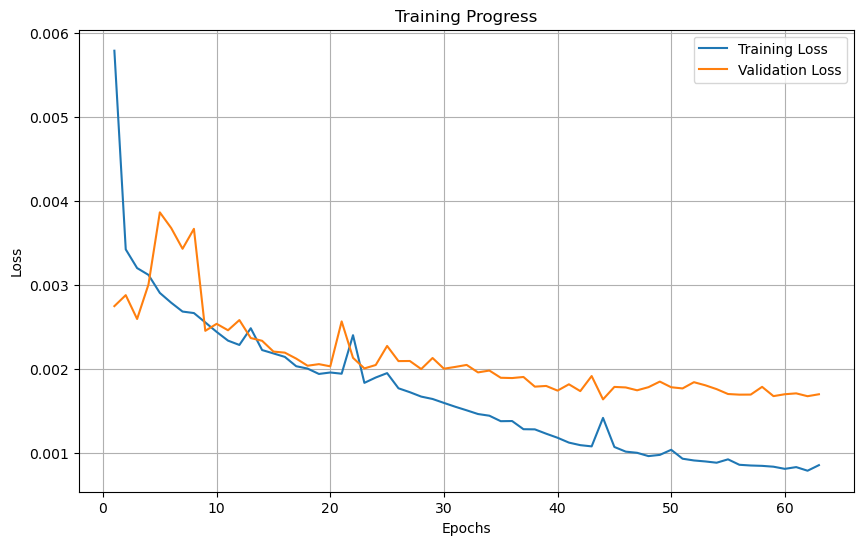

In [27]:
model.plot_training_curves()

In [28]:
model.get_R2_score(y_scaler, output_features)

Feature N2O_FLUX R2 Score is: 0.9999973055373217
Feature CO2_FLUX R2 Score is: 0.9997620985708515
Feature WTR_3 R2 Score is: 0.9867037553482527
Feature NH4_3 R2 Score is: 0.9934750541782907
Feature NO3_3 R2 Score is: 0.999992482150139


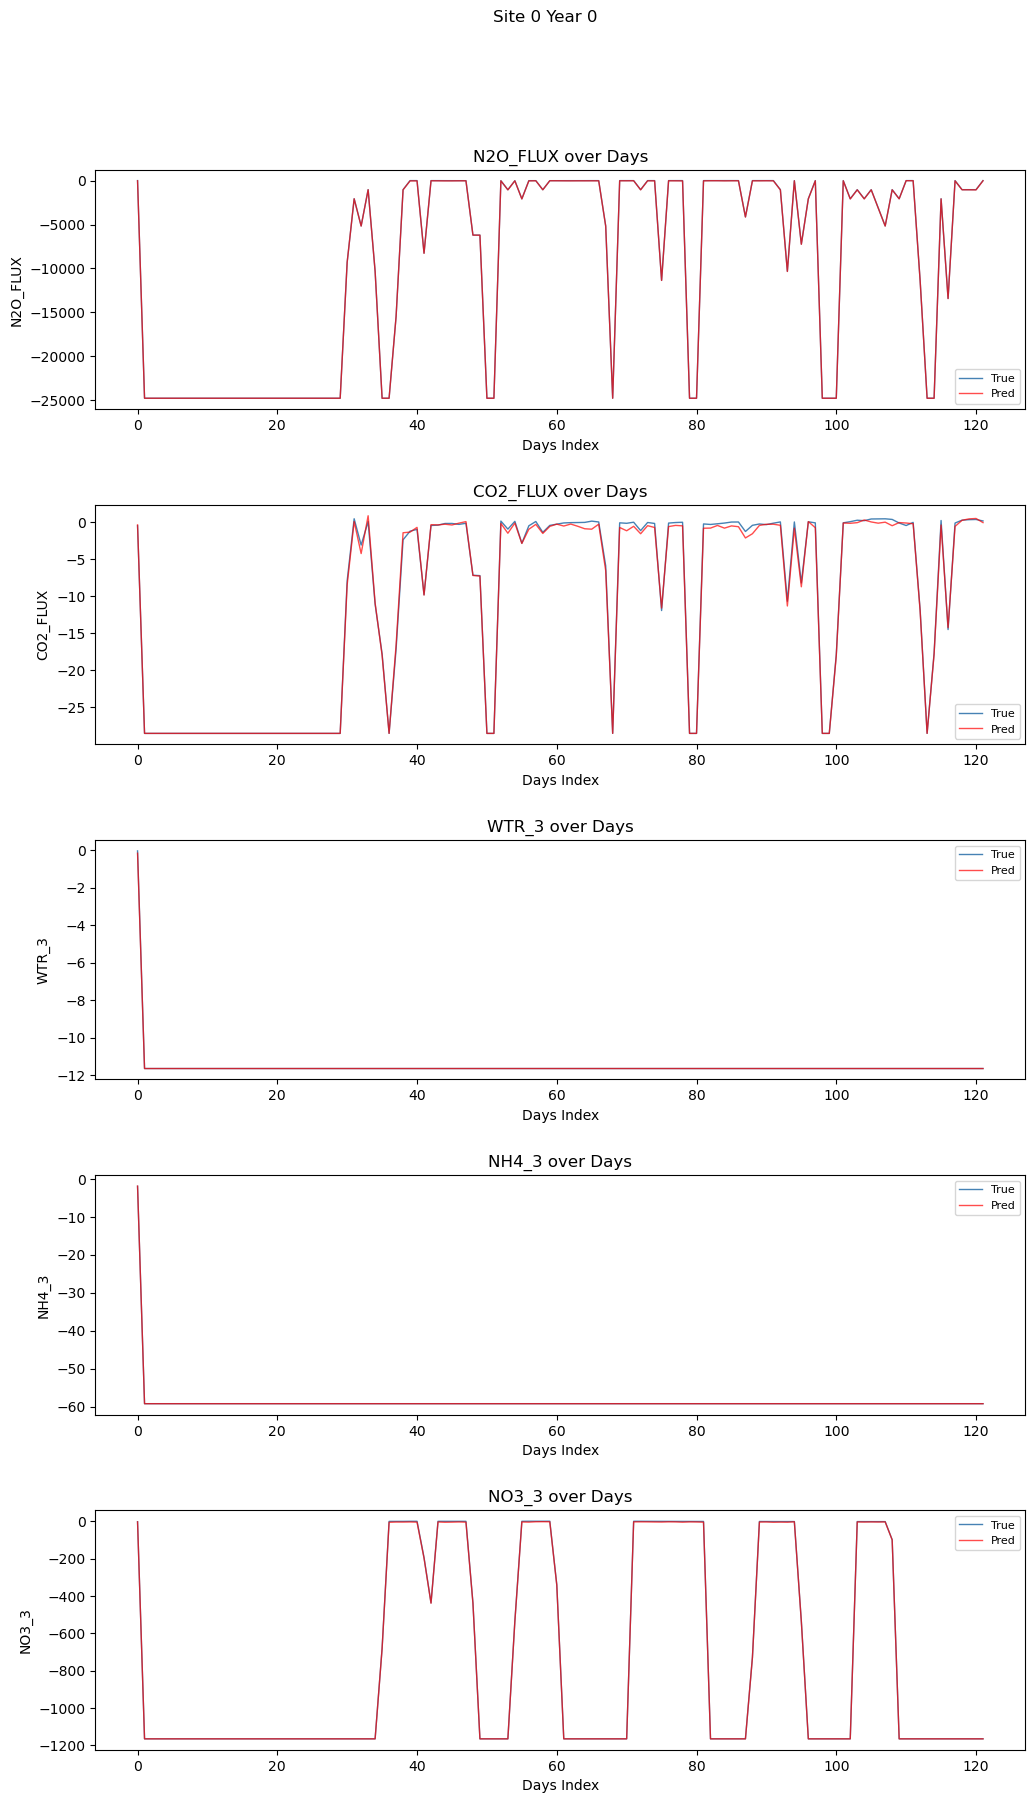

In [30]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_features, site=0, year=0)

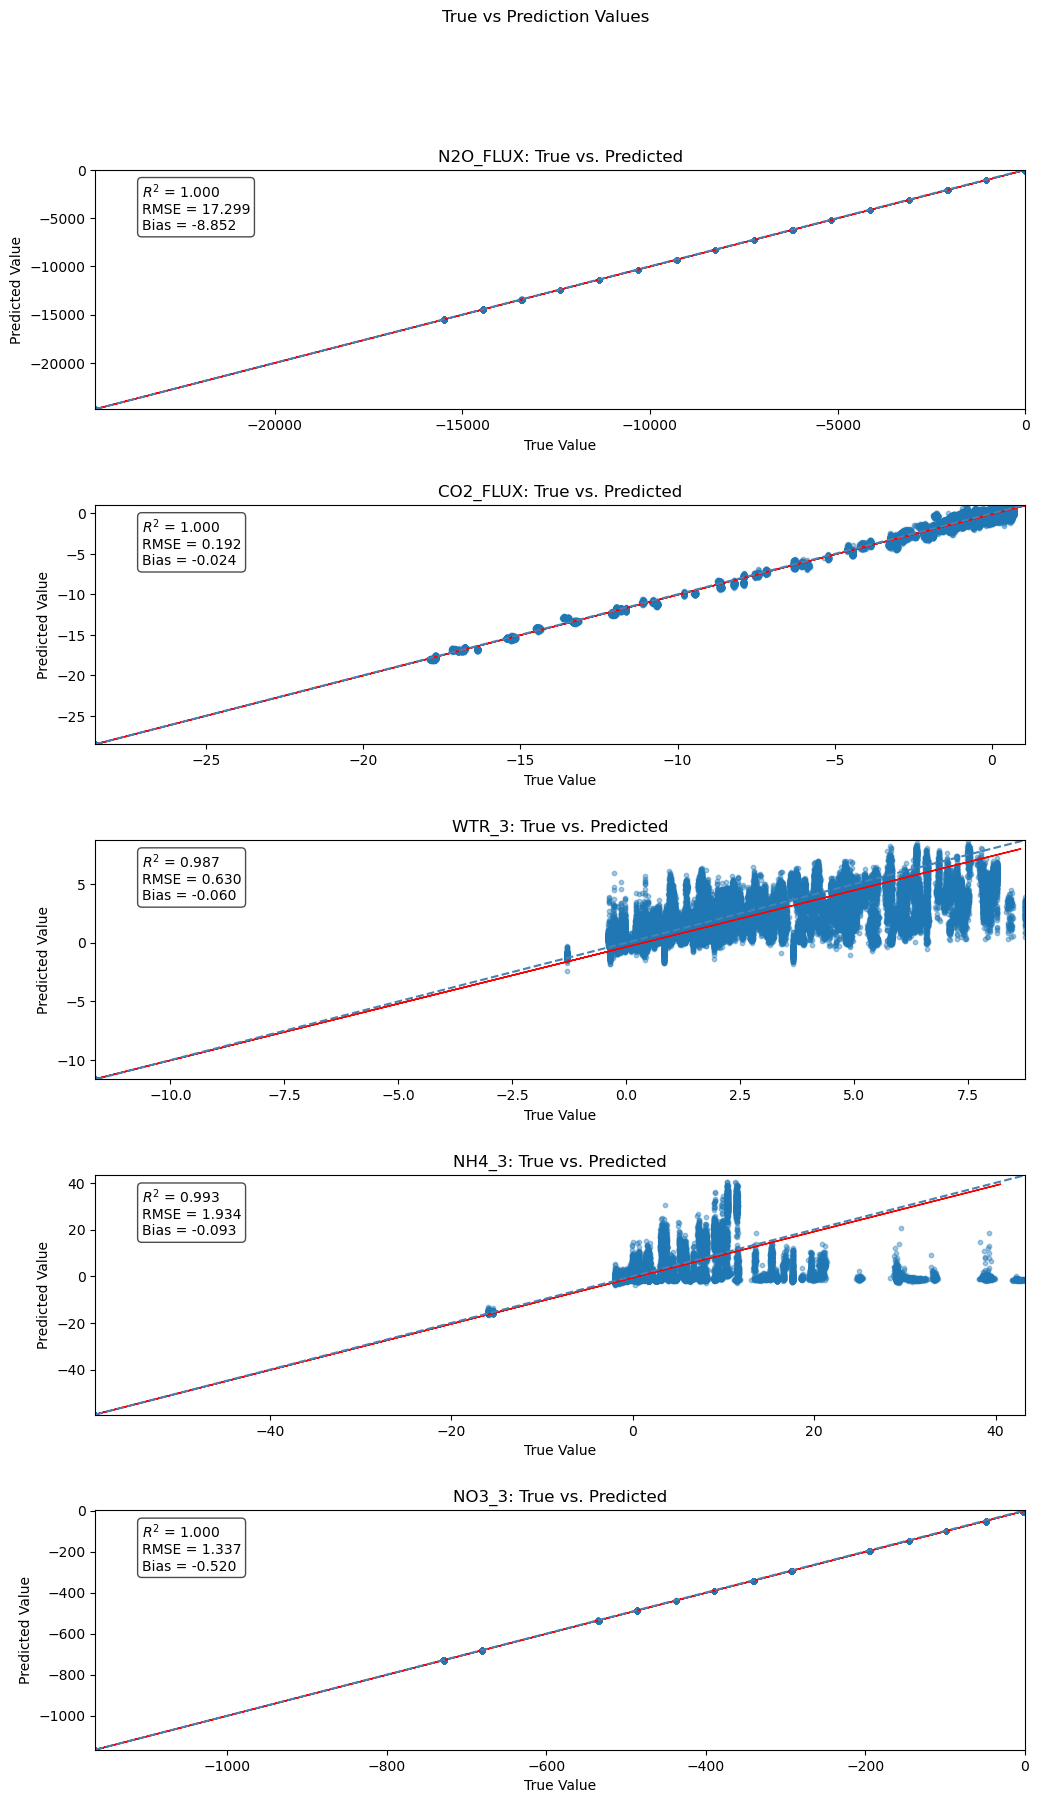

In [31]:
model.Vis_scatter_prediction_result(y_scaler, output_features)